## Twitter Sentiment Analysis

Read in the date. Source: http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

In [1]:
import numpy as np
import pandas as pd
import nltk
from pprint import pprint
import matplotlib.pyplot as plt

url = 'http://thinknook.com/wp-content/uploads/2012/09/Sentiment-Analysis-Dataset.zip'
tweet_data = pd.read_csv(url, compression='zip', error_bad_lines=False, warn_bad_lines=False)
tweet_data.drop(['ItemID', 'SentimentSource'],axis=1,inplace=True)
tweet_data.columns = ['label', 'tweet']
    
print "Twitter sentiment dataset has {} data points with {} variables each.".format(*tweet_data.shape)

tweet_data.head()

Twitter sentiment dataset has 1578612 data points with 2 variables each.


,label,tweet
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


Looking at some positive and negative tweets.

In [2]:
print("Positive tweets:\n")
pprint(list(tweet_data[tweet_data['label'] == 1].tweet)[:5], width=200)

print("\nNegative tweets:\n")
pprint(list(tweet_data[tweet_data['label'] == 0].tweet)[:5], width=200)

Positive tweets:

['              omg its already 7:30 :O',
 '       Juuuuuuuuuuuuuuuuussssst Chillin!!',
 '      handed in my uniform today . i miss you already',
 '      hmmmm.... i wonder how she my number @-)',
 '      thanks to all the haters up in my face all day! 112-102']

Negative tweets:

['                     is so sad for my APL friend.............',
 '                   I missed the New Moon trailer...',
 "          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...",
 '         i think mi bf is cheating on me!!!       T_T',
 '         or i just worry too much?        ']


### Data Preprocessing

Let's get a list of stop words to be removed from further processing and have a look at the first 20 stop words.

In [3]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words = [word.encode('UTF8') for word in stop_words]
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


Let's preprocess the tweet texts by breaking them down into words using a tokenizer and removing the stopwords.

In [4]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def process_tweet(tweet):
    toks = tokenizer.tokenize(tweet)
    toks = [t.lower() for t in toks if t.lower() not in stop_words and len(t) >= 3]
    return toks

def process_text(tweets):
    tokens = []
    for tweet in tweets:
        toks = process_tweet(tweet)
        tokens.extend(toks)
    return tokens

In [5]:
all_tweets = list(tweet_data.tweet)

tweet_tokens = process_text(all_tweets)
token_freq = nltk.FreqDist(tweet_tokens)

### Checking Zipf's Law

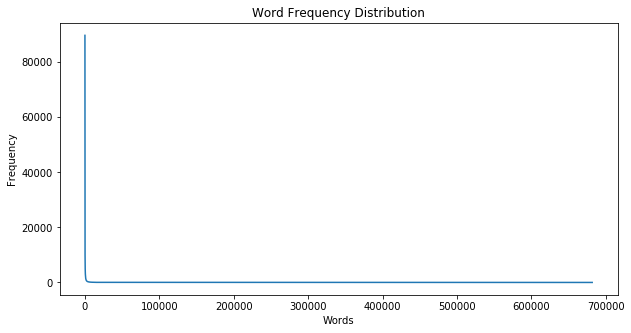

In [6]:
y_val = [x[1] for x in token_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution")
plt.show()

The above graph looks like the data fits under Zipf's Law. Let's look at the log-log plot to confirm it.

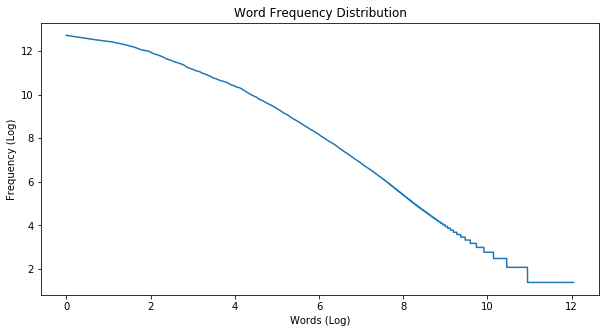

In [7]:
import math

y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution")
plt.plot(x_val, y_final)
plt.show()

As expected, the log-log-plot almost looks like a straight line with a noisy tail. This confirms that our data fits under the Zipf's law.

### Predicting Sentiment

Splitting data into test and training set.

In [8]:
train_data = tweet_data.iloc[:120000]
test_data = tweet_data.iloc[120000:]

In [9]:
train_data.to_csv('train.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [10]:
import csv

with open("train.csv", 'r') as file:
    train_tweets = list(csv.reader(file))
    
with open("test.csv", 'r') as file:
    test_tweets = list(csv.reader(file))

Training Multinomial Naive Bayes classifier with our training data.

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

vectorizer = CountVectorizer(stop_words='english', max_df=.05)
train_features = vectorizer.fit_transform([r[1] for r in train_tweets])
test_features = vectorizer.transform([r[1] for r in test_tweets])

In [12]:
nb = MultinomialNB()
nb.fit(train_features, [int(r[0]) for r in train_tweets])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Making predictions on the test data.

In [13]:
predictions = nb.predict(test_features)

Checking the accuracy using the ROC curve. The closer it is to 1 the "better".

In [14]:
from sklearn import metrics

actual = [int(r[0]) for r in test_tweets]

fpr, tpr, thresholds = metrics.roc_curve(actual, predictions, pos_label=1)
print("Multinomal naive bayes AUC: {0}".format(metrics.auc(fpr, tpr)))

Multinomal naive bayes AUC: 0.739396143118


The process of data cleaning could be heavily improved. @ mentions, numbers, and URLs could be removed. It would also be possible to test other ML algorithms.

### Getting the top 10 positive and negative words

In [15]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

Source: https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

In [16]:
show_most_informative_features(vectorizer, nb, n=10)

	-13.2949	0001t          		-4.4488	quot           
	-13.2949	00mony00       		-4.9193	thanks         
	-13.2949	00neji         		-4.9281	love           
	-13.2949	00seve         		-5.2846	know           
	-13.2949	0130           		-5.4244	ll             
	-13.2949	0132           		-5.4305	http           
	-13.2949	01ps           		-5.4562	day            
	-13.2949	021            		-5.4633	haha           
	-13.2949	02345          		-5.6019	great          
	-13.2949	0292070616     		-5.6115	amp            


The list of the most informative features on the right side shows that more data cleaning would heavily improve the prediction. If I used Naive Bayes from NLTK we would have a nicer list of most informative features. MultinomialNB from sklearn made it possible to make predictions with very few lines of code and very little preprocessing.